 Prepare the general libraries.

In [1]:
# libraries
library(community)
library(ggplot2)

 Prepare the path.

In [2]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- 'computed_results/'

print("path_in")
print(path_in)

[1] "path_in"
[1] "computed_results/"


Load data.

In [3]:
suppressWarnings(load(paste0(path_in,"/interactions.RData")))

Load functions for visualization.

In [4]:
data("visualization_functions")

In [5]:
ls()

[1] "interactions"                    "mean_weights"                   
 [3] "number_interactions"             "order_interactions_for_forests" 
 [5] "path_in"                         "plor_celltype_network"          
 [7] "plot_all_forests"                "plot_cell_type_annotation"      
 [9] "plot_forest"                     "plot_heatmap"                   
[11] "plot_nrInt_vs_meanW_perCellType" "plot_stacked_bar"               
[13] "plot_vulcano"

## Parameters

In [5]:
# threshold for log2FC of the weights
threshold_log2FC <- interactions$thresholds$threshold_log2FC

idx_up <- interactions$anno_interactions$log2FC_weights > threshold_log2FC
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<= threshold_log2FC
idx_down <- interactions$anno_interactions$log2FC_weights < -threshold_log2FC
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [6]:
# extract cell types
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Mono" "Gran" "T"    "NK"   "B"    "HSPC" "Ery"  "DC"  


In [7]:
# define broad type of interactions by cell types
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]

interaction_cell_types <- unique(paste(interactions$anno_interactions$sending_cell_type
                                ,interactions$anno_interactions$receiving_cell_type
                                ,sep = " to "))

interaction_type <- sapply(interaction_cell_types
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type))

interaction_type_by_ID <- sapply(interactions$anno_interactions$interaction_ID
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type_by_ID))

colors_interaction_type <- c("engages HSPC" = "magenta"
                             ,"among immune cells" = "deepskyblue"
                             ,"engages Ery" = "darkgoldenrod3"#"lightgoldenrod"
                            )
print(colors_interaction_type)

 Named chr [1:64] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:64] "Mono to Mono" "Mono to Gran" "Mono to T" "Mono to NK" ...
NULL
 Named chr [1:151744] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:151744] "Mono:JAG2_Mono:NOTCH1" "Mono:DLL1_Mono:NOTCH1" "Mono:IGF1_Mono:IGF1R" "Mono:JAG1_Mono:NOTCH1" ...
NULL
      engages HSPC among immune cells        engages Ery 
         "magenta"      "deepskyblue"   "darkgoldenrod3" 


## Visualization: all good quality interactions

### Mean weight vs mean number 

In [8]:
library(ggrepel) # to add text labels on the mean weigth vs number of interactions plot

In [9]:
# claclulate mean weight of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
mean_weights_goodInteractions <- mean_weights(interactions)

print(str(mean_weights_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.04324 0.04169 0.01213 0.00967 0.00597 ...
  ..$ Gran: num [1:8] 0.0407 0.05547 0.01301 0.00913 0.01859 ...
  ..$ T   : num [1:8] 0.0113 0.0166 0.0923 0.078 0.0237 ...
  ..$ NK  : num [1:8] 0.00926 0.01162 0.07798 0.07479 0.01586 ...
  ..$ B   : num [1:8] 0.00493 0.01885 0.02199 0.0149 0.01931 ...
  ..$ HSPC: num [1:8] 0.0114 0.0283 0.0285 0.0184 0.0248 ...
  ..$ Ery : num [1:8] 0.00124 0.00595 0.00821 0.00289 0.00763 ...
  ..$ DC  : num [1:8] 0.0126 0.019 0.0299 0.027 0.0071 ...
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.0296 0.0468 0.0234 0.0209 0.0269 ...
  ..$ Gran: num [1:8] 0.0429 0.0785 0.0339 0.0268 0.0425 ...
  ..$ T   : num [1:8] 0.0256 0.0385 0.0353 0.0233 0.0344 ...
  ..$ NK  : num [1:8] 0.0219 0.0282 0.0226 0.0187 0.0197 ...
  ..$ B   : num [1:8] 0.0278 0.0476 0.0319 0.0183 0.0544 ...
  ..$ HSPC: num [1:8] 0.00699 0.01193 0.00572 0.00466 0.0067 ...
  ..$ Ery : nu

In [10]:
# claclulate number of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
number_goodInteractions <- number_interactions(interactions)

print(str(number_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 839 619 582 413 449 531 221 558
  ..$ Gran: int [1:8] 632 472 457 314 362 415 288 437
  ..$ T   : int [1:8] 593 444 498 347 389 425 280 454
  ..$ NK  : int [1:8] 370 281 295 224 225 256 111 283
  ..$ B   : int [1:8] 350 276 294 194 225 257 172 266
  ..$ HSPC: int [1:8] 489 362 406 260 312 412 244 325
  ..$ Ery : int [1:8] 175 218 230 96 199 225 175 142
  ..$ DC  : int [1:8] 554 405 421 296 314 347 154 417
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 840 620 602 424 473 532 228 604
  ..$ Gran: int [1:8] 638 478 470 333 370 420 295 476
  ..$ T   : int [1:8] 616 455 498 347 393 426 280 477
  ..$ NK  : int [1:8] 377 290 295 224 228 258 113 296
  ..$ B   : int [1:8] 359 281 295 199 225 255 172 283
  ..$ HSPC: int [1:8] 481 367 400 264 304 388 244 353
  ..$ Ery : int [1:8] 187 230 231 96 199 225 175 200
  ..$ DC  : int [1:8] 623 468 449 321 350 383 208 468
NULL


In [11]:
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]
grepl(paste(immune_cell_types, collapse="|"), "B cell")

[1] TRUE

'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.04324 0.04169 0.01213 0.00967 0.00597 ...
 $ number_of_interactions : int  839 619 582 413 449 531 221 558 632 472 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL
'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.0296 0.0468 0.0234 0.0209 0.0269 ...
 $ number_of_interactions : int  840 620 602 424 473 532 228 604 638 478 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL


Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 53 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[[1]]

[[2]]


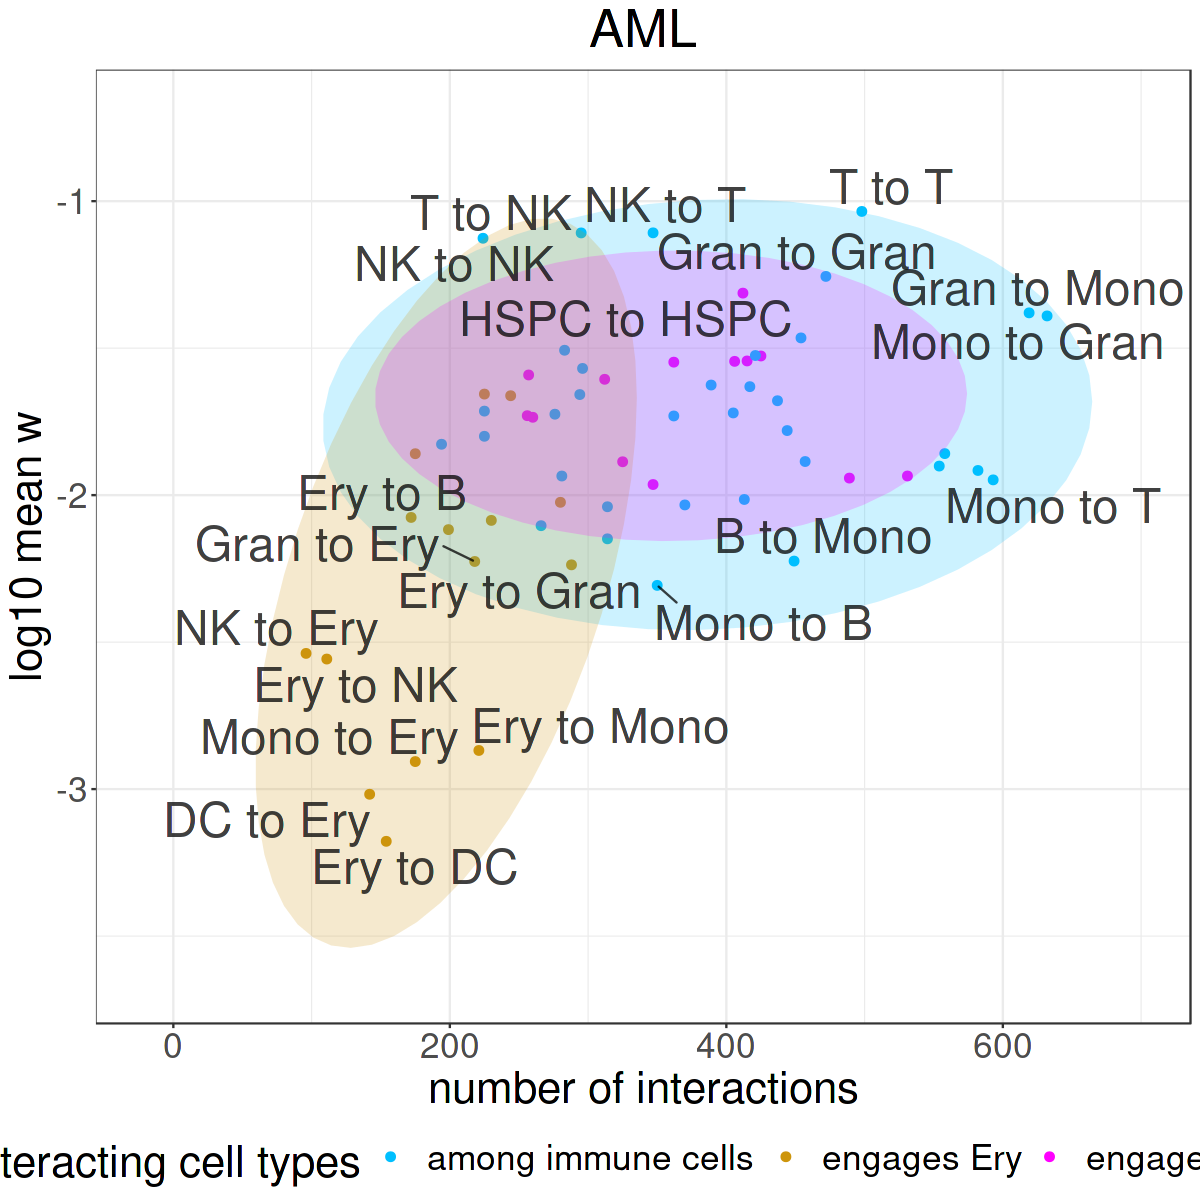

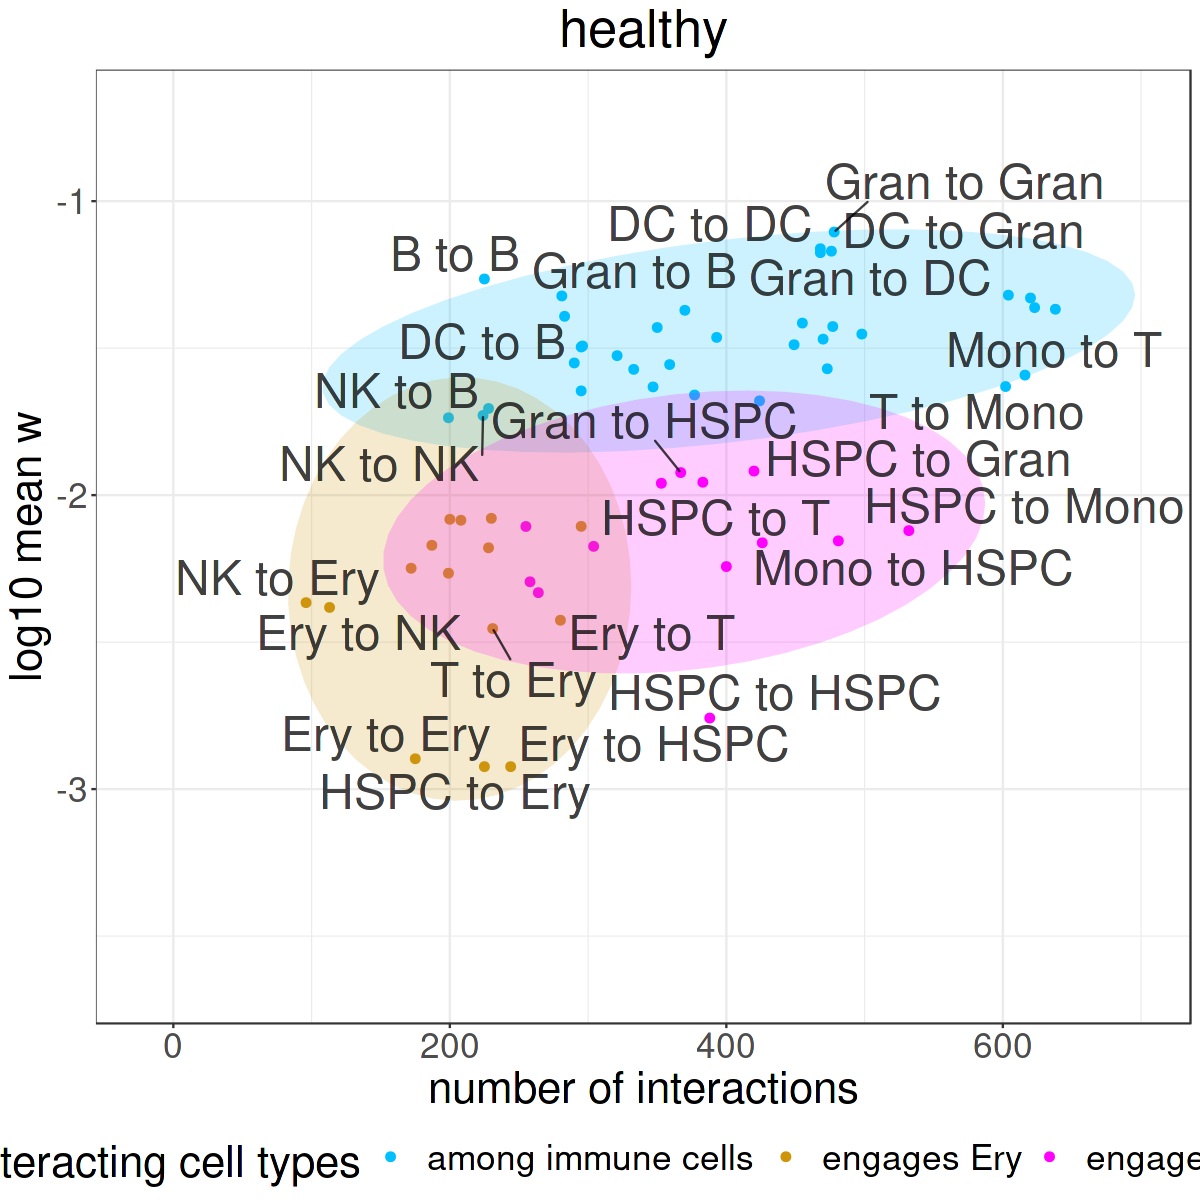

In [12]:
# plot mumber of interactions vs mean interaction weights per cell type to cell type interaction
options(repr.plot.width = 10
        ,repr.plot.height = 10)

ylim <- c(-3.65, -0.7)
xlim <- c(-20, 700)

plot_nrInt_vs_meanW_perCellType(interactions
                               ,interaction_type = interaction_type
                               ,colors = colors_interaction_type
                               ,ylim = ylim
                               ,label_font_size = 10)

## Visualization of differential interactions

### Voclano

In [13]:
print("downregulated:")
print(sum(idx_down & idx_sign))

print("upregulated:")
print(sum(idx_up & idx_sign))

[1] "downregulated:"
[1] 2670
[1] "upregulated:"
[1] 109


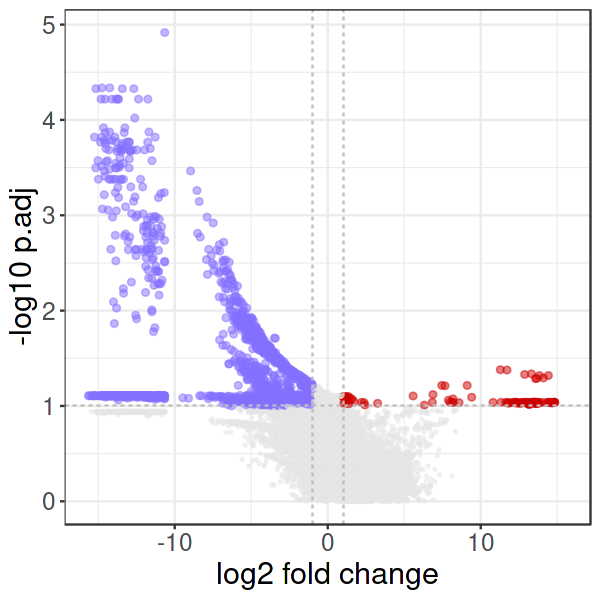

In [14]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 5)
    
plot_vulcano(interactions)

### Heatmap top differential

In [15]:
library(ComplexHeatmap) # to plot heatmaps
library(circlize) # for gragient colors

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

Thi

In [16]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:300]
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:10]

# all upregulated interactions
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign
idx_topup <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topup][1:9]

idx <- idx_topup | idx_topdown

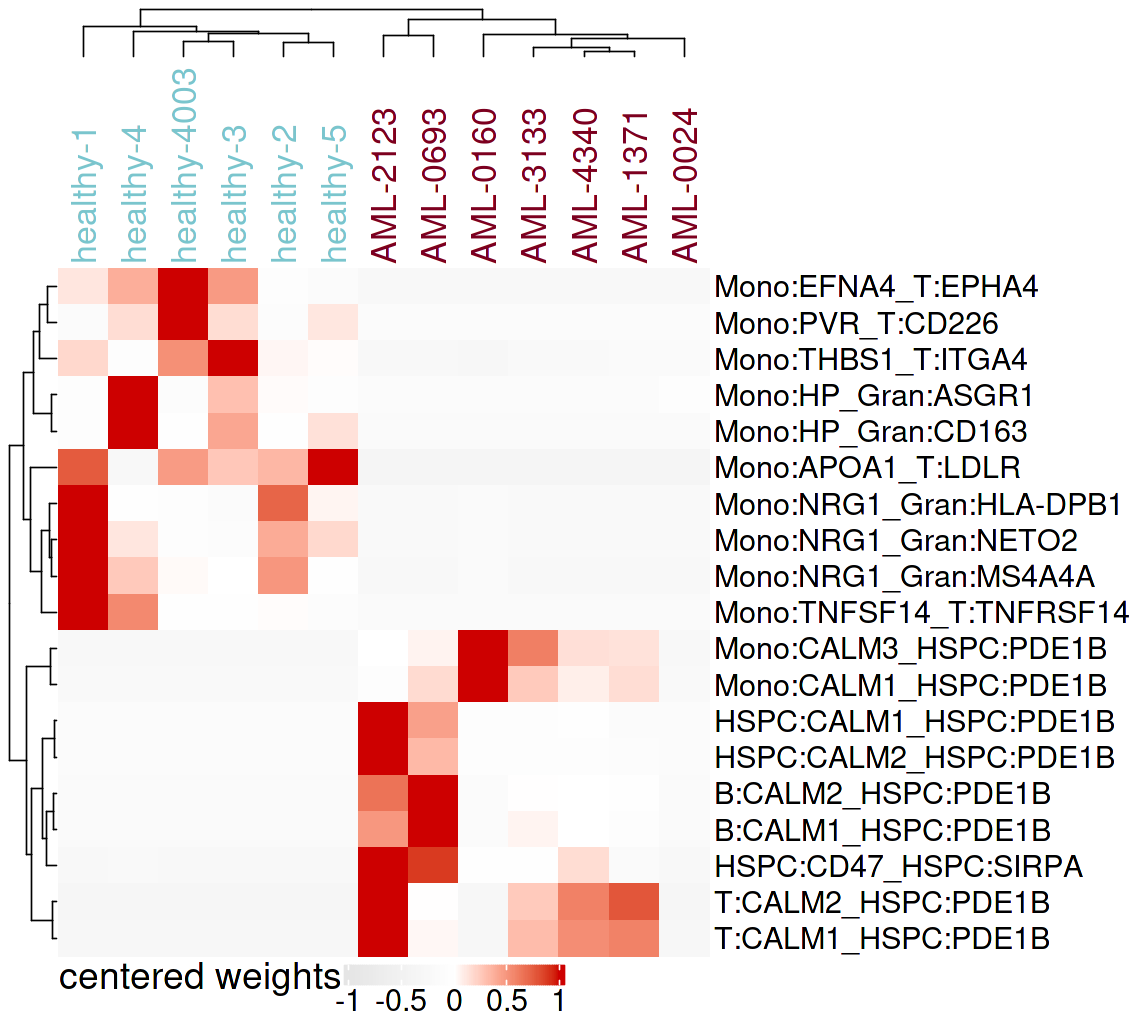

In [17]:
# centred Heatmap
set.seed(3)
options(repr.plot.height = 8.5
       ,repr.plot.width = 9.5
       )
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights"
            ,row_font_size =18
            ,column_font_size = 20
             ,centered = TRUE
             ,color_values = circlize::colorRamp2(c(-1,0,1), c("gray90","white", "red3"))
             ,legend_title_font_size = 22
             ,labels_font_size = 18
            )

### Network plots

In [18]:
library(igraph) # to plot circus plots


Attaching package: ‘igraph’


The following object is masked from ‘package:circlize’:

    degree


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




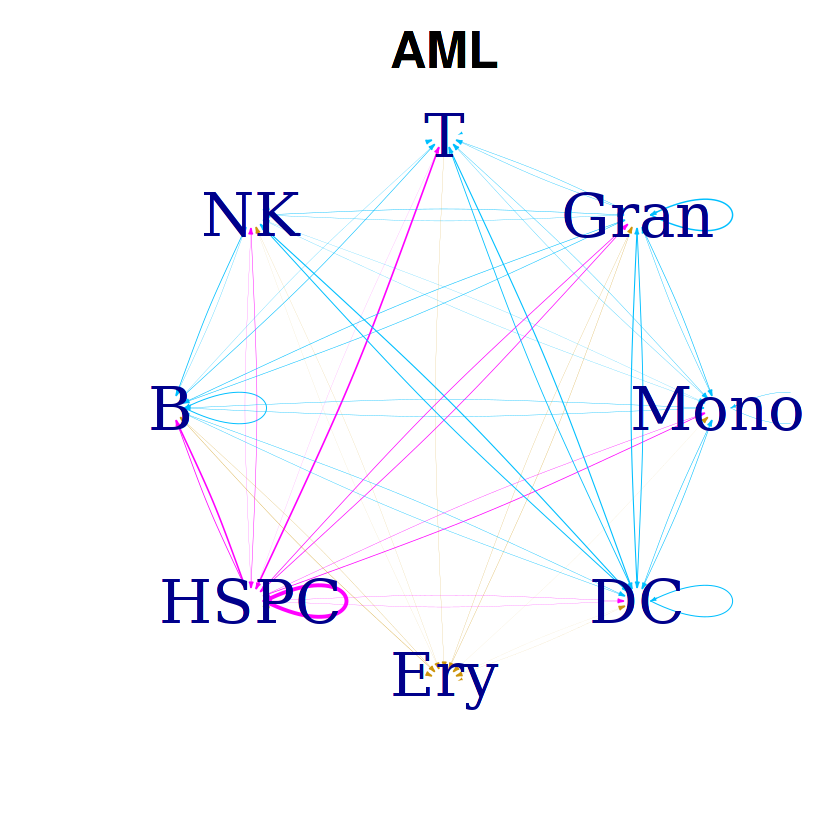

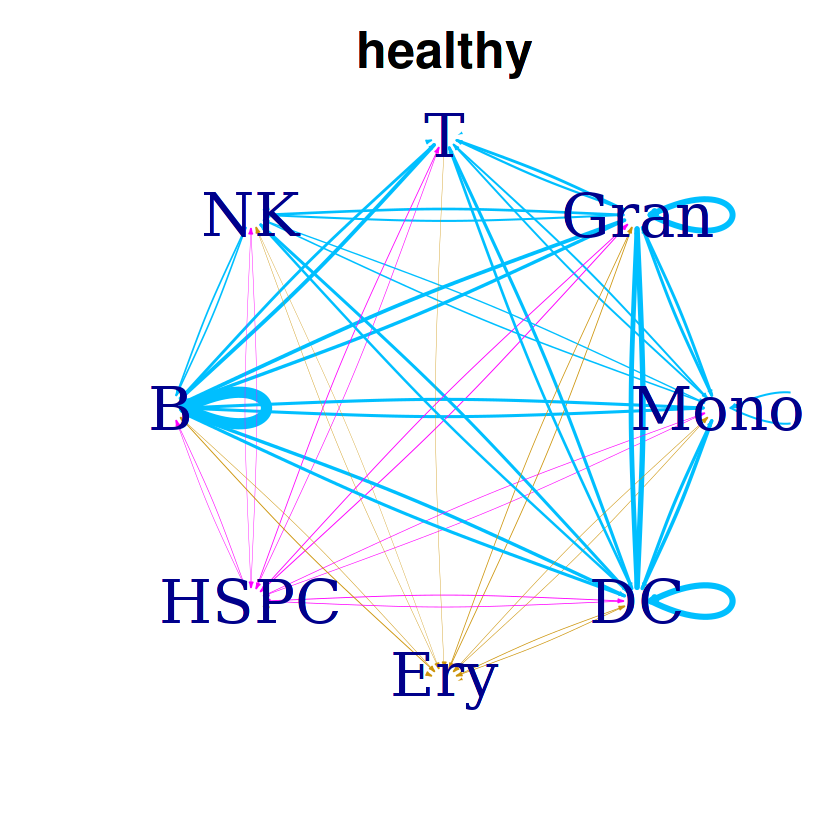

In [19]:
options(repr.plot.width = 7
       ,repr.plot.height = 7)

colors <- colors_interaction_type[interaction_type]
names(colors) <- names(interaction_type)

plor_celltype_network(interactions
                     ,edge.color = colors
                     ,title_cex = 2.5
                     ,vertex.label.cex = 3
                     ,edge.arrow.size = 0.2
                     ,verbose = FALSE
                     )

## Visualization of individual components

<img src="../components_scheme.png">

### Forest plots

In [20]:
library(gridExtra) 

In [22]:
# ADD THIS FUNCTION TO THE 'VISUALIZATION FUNCTIONS' AND REMOVE THE CHUNK!!!!!!!!!!!!!!!!

# Input
# interactions

# Output
# ordered_IDs -- list of interactions IDs grouped into categorites by the interplay of components

order_IDs_by_interaction_categories <- function(interactions){
    
    # indices
    
    idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
    idx_good <- interactions$anno_interactions$passed_QC_filter
    
    idx_up <- interactions$anno_interactions$log2FC_weights >1
    idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
    idx_down <- interactions$anno_interactions$log2FC_weights < -1
    
    idx_only_rho_s <- interactions$anno_interactions$components_affected_s == "rho" & interactions$anno_interactions$nr_comp_affected_b == 1 
    idx_only_rho_r <- interactions$anno_interactions$components_affected_r == "rho" & interactions$anno_interactions$nr_comp_affected_b == 1 
    idx_only_phi_s <- interactions$anno_interactions$components_affected_s == "phi" & interactions$anno_interactions$nr_comp_affected_b == 1 
    idx_only_phi_r <- interactions$anno_interactions$components_affected_r == "phi" & interactions$anno_interactions$nr_comp_affected_b == 1 
    idx_only_p_s <- interactions$anno_interactions$components_affected_s == "p" & interactions$anno_interactions$nr_comp_affected_b == 1 
    idx_only_p_r <- interactions$anno_interactions$components_affected_r == "p" & interactions$anno_interactions$nr_comp_affected_b == 1 
    
    idx_nrComp_s_none <- interactions$anno_interactions$nr_comp_affected_s == 0
    idx_nrComp_s_one <- interactions$anno_interactions$nr_comp_affected_s == 1
    idx_nrComp_s_several <- interactions$anno_interactions$nr_comp_affected_s >1
    
    idx_nrComp_r_none <- interactions$anno_interactions$nr_comp_affected_r == 0
    idx_nrComp_r_one <- interactions$anno_interactions$nr_comp_affected_r == 1
    idx_nrComp_r_several <- interactions$anno_interactions$nr_comp_affected_r >1
    
    idx_no_change <- interactions$anno_interactions$interaction_category == "no_change"
    idx_simple_decrease <- interactions$anno_interactions$interaction_category == "simple_decrease"
    idx_simple_increase <- interactions$anno_interactions$interaction_category == "simple_increase"
    idx_concordant_decrease <- interactions$anno_interactions$interaction_category == "concordant_decrease"
    idx_concordant_increase <- interactions$anno_interactions$interaction_category == "concordant_increase"
    idx_insufficient_comp <- interactions$anno_interactions$interaction_category == "insufficient_compensation"
    idx_sufficient_comp <- interactions$anno_interactions$interaction_category == "sufficient_compensation"

    # ordered IDs

    # no change
    ID_order_no_change <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                         idx_good &
                                                                                         idx_no_change
                                                                                       ,]
                                                       )$interaction_ID
    
    # simpe down: rho_s -> phi_s -> p_s -> rho_r -> phi_r -> p_r
    ID_order_rho_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_decrease &
                                                                                         idx_only_rho_s 
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_phi_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_decrease &
                                                                                         idx_only_phi_s 
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_p_s_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_simple_decrease &
                                                                                       idx_only_p_s 
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_rho_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_decrease &
                                                                                         idx_only_rho_r
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_phi_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_decrease &
                                                                                         idx_only_phi_r
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_p_r_only_down <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_simple_decrease &
                                                                                       idx_only_p_r 
                                                                                       ,]
                                                       )$interaction_ID
    
    # simpe up: rho_s -> phi_s -> p_s -> rho_r -> phi_r -> p_r
    ID_order_rho_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_increase &
                                                                                         idx_only_rho_s 
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_phi_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_increase &
                                                                                         idx_only_phi_s 
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_p_s_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_simple_increase &
                                                                                       idx_only_p_s 
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_rho_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_increase &
                                                                                         idx_only_rho_r
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_phi_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                         idx_simple_increase &
                                                                                         idx_only_phi_r
                                                                                        ,]
                                                       )$interaction_ID
    
    ID_order_p_r_only_up <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_simple_increase &
                                                                                       idx_only_p_r 
                                                                                       ,]
                                                       )$interaction_ID
    
    # concordant down: sender -> receiver -> both
    ID_order_concordantDown_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantDown_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_r_several &
                                                                                       idx_nrComp_s_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantDown_b_one_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_s_one &
                                                                                       idx_nrComp_r_one
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantDown_b_one_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_s_one &
                                                                                       idx_nrComp_r_several
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantDown_b_several_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_one
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantDown_b_several_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_decrease &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_several
                                                                                       ,]
                                                       )$interaction_ID
    
    # concordant up: sender -> receiver -> both
    ID_order_concordantUp_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantUp_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_r_several &
                                                                                       idx_nrComp_s_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantUp_b_one_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_s_one &
                                                                                       idx_nrComp_r_one
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantUp_b_one_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_s_one &
                                                                                       idx_nrComp_r_several
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantUp_b_several_one <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_one
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_concordantUp_b_several_several <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_concordant_increase &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_several
                                                                                       ,]
                                                       )$interaction_ID
    
    # insufficiend compensation down: sender -> receiver -> both
    ID_order_insuffDown_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_down & 
                                                                                       idx_insufficient_comp &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_insuffDown_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_down & 
                                                                                       idx_insufficient_comp &
                                                                                       idx_nrComp_r_several &
                                                                                       idx_nrComp_s_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_insuffDown_b <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_down & 
                                                                                       idx_insufficient_comp &
                                                                                       (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                       (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                       ,]
                                                       )$interaction_ID
    
    # insufficiend compensation up: sender -> receiver -> both
    ID_order_insuffUp_s <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_up & 
                                                                                       idx_insufficient_comp &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_insuffUp_r <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_up & 
                                                                                       idx_insufficient_comp &
                                                                                       idx_nrComp_r_several &
                                                                                       idx_nrComp_s_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_insuffUp_b <- order_interactions_for_forests(interactions$anno_interactions[idx_sign & 
                                                                                       idx_up & 
                                                                                       idx_insufficient_comp &
                                                                                       (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                       (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                       ,]
                                                       )$interaction_ID
    
    # sufficient compensation: sender -> receiver -> both
    ID_order_suffComp_s <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                         idx_good &
                                                                                       idx_sufficient_comp &
                                                                                       idx_nrComp_s_several &
                                                                                       idx_nrComp_r_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_suffComp_r <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                         idx_good &
                                                                                       idx_sufficient_comp &
                                                                                       idx_nrComp_r_several &
                                                                                       idx_nrComp_s_none
                                                                                       ,]
                                                       )$interaction_ID
    
    ID_order_suffComp_b <- order_interactions_for_forests(interactions$anno_interactions[!idx_sign & 
                                                                                         idx_good &
                                                                                       idx_sufficient_comp &
                                                                                       (idx_nrComp_s_one | idx_nrComp_s_several) &
                                                                                       (idx_nrComp_r_one | idx_nrComp_r_several)
                                                                                       ,]
                                                       )$interaction_ID
    ordered_IDs <- list(ID_order_no_change = as.character(ID_order_no_change)
                          ,ID_order_rho_s_only_down = as.character(ID_order_rho_s_only_down)
                          ,ID_order_phi_s_only_down = as.character(ID_order_phi_s_only_down)
                          ,ID_order_p_s_only_down = as.character(ID_order_p_s_only_down)
                          ,ID_order_rho_r_only_down = as.character(ID_order_rho_r_only_down)
                          ,ID_order_phi_r_only_down = as.character(ID_order_phi_r_only_down)
                          ,ID_order_p_r_only_down = as.character(ID_order_p_r_only_down)
                          ,ID_order_rho_s_only_up = as.character(ID_order_rho_s_only_up)
                          ,ID_order_phi_s_only_up = as.character(ID_order_phi_s_only_up)
                          ,ID_order_p_s_only_up = as.character(ID_order_p_s_only_up)
                          ,ID_order_rho_r_only_up = as.character(ID_order_rho_r_only_up)
                          ,ID_order_phi_r_only_up = as.character(ID_order_phi_r_only_up)
                          ,ID_order_p_r_only_up = as.character(ID_order_p_r_only_up)
                          ,ID_order_concordantDown_s = as.character(ID_order_concordantDown_s)
                          ,ID_order_concordantDown_r = as.character(ID_order_concordantDown_r)
                          ,ID_order_concordantDown_b_one_one = as.character(ID_order_concordantDown_b_one_one)
                          ,ID_order_concordantDown_b_one_several = as.character(ID_order_concordantDown_b_one_several)
                          ,ID_order_concordantDown_b_several_one = as.character(ID_order_concordantDown_b_several_one)
                          ,ID_order_concordantDown_b_several_several = as.character(ID_order_concordantDown_b_several_several)
                          ,ID_order_concordantUp_s = as.character(ID_order_concordantUp_s)
                          ,ID_order_concordantUp_r = as.character(ID_order_concordantUp_r)
                          ,ID_order_concordantUp_b_one_one = as.character(ID_order_concordantUp_b_one_one)
                          ,ID_order_concordantUp_b_one_several = as.character(ID_order_concordantUp_b_one_several)
                          ,ID_order_concordantUp_b_several_one = as.character(ID_order_concordantUp_b_several_one)
                          ,ID_order_concordantUp_b_several_several = as.character(ID_order_concordantUp_b_several_several)
                          ,ID_order_insuffDown_s = as.character(ID_order_insuffDown_s)
                          ,ID_order_insuffDown_r = as.character(ID_order_insuffDown_r)
                          ,ID_order_insuffDown_b = as.character(ID_order_insuffDown_b)
                          ,ID_order_insuffUp_s = as.character(ID_order_insuffUp_s)
                          ,ID_order_insuffUp_r = as.character(ID_order_insuffUp_r)
                          ,ID_order_insuffUp_b = as.character(ID_order_insuffUp_b)
                          ,ID_order_suffComp_s = as.character(ID_order_suffComp_s)
                          ,ID_order_suffComp_r = as.character(ID_order_suffComp_r)
                          ,ID_order_suffComp_b = as.character(ID_order_suffComp_b)
                       )
    return(ordered_IDs)
    }

In [21]:
ordered_IDs <- order_IDs_by_interaction_categories(interactions)
print(str(ordered_IDs))
print(length(unlist(ordered_IDs)))

ERROR: Error in order_IDs_by_interaction_categories(interactions): could not find function "order_IDs_by_interaction_categories"


#### Split by category

In [23]:
# ADD THIS FUNCTION TO THE 'VISUALIZATION FUNCTIONS' AND REMOVE THE CHUNK!!!!!!!!!!!!!!!!

# input
# interactions
# ordered_IDs

# output
# component_lim -- list of min an dmax limits for all the components of the forest plot

find_component_limits <- function(interactions
                               ,ordered_IDs){
    rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
    of_interest <- interactions$anno_interactions[unlist(ordered_IDs),]
    
    idx_log2FC_w_min <- of_interest$log2FC_weights == min(of_interest$log2FC_weights)
    idx_log2FC_w_max <- of_interest$log2FC_weights == max(of_interest$log2FC_weights)
    
    idx_log2FC_rho_s_min <- of_interest$log2FC_rho_s == min(of_interest$log2FC_rho_s)
    idx_log2FC_rho_s_max <- of_interest$log2FC_rho_s == max(of_interest$log2FC_rho_s)
    
    idx_log2FC_phi_s_min <- of_interest$log2FC_phi_s_l == min(of_interest$log2FC_phi_s_l)
    idx_log2FC_phi_s_max <- of_interest$log2FC_phi_s_l == max(of_interest$log2FC_phi_s_l)
    
    idx_log2FC_p_s_min <- of_interest$log2FC_p_s_l == min(of_interest$log2FC_p_s_l)
    idx_log2FC_p_s_max <- of_interest$log2FC_p_s_l == max(of_interest$log2FC_p_s_l)
    
    idx_log2FC_rho_r_min <- of_interest$log2FC_rho_r == min(of_interest$log2FC_rho_r)
    idx_log2FC_rho_r_max <- of_interest$log2FC_rho_r == max(of_interest$log2FC_rho_r)
    
    idx_log2FC_phi_r_min <- of_interest$log2FC_phi_r_r == min(of_interest$log2FC_phi_r_r)
    idx_log2FC_phi_r_max <- of_interest$log2FC_phi_r_r == max(of_interest$log2FC_phi_r_r)
    
    idx_log2FC_p_r_min <- of_interest$log2FC_p_r_r == min(of_interest$log2FC_p_r_r)
    idx_log2FC_p_r_max <- of_interest$log2FC_p_r_r == max(of_interest$log2FC_p_r_r)
    
    #rm(of_interest)
    
    component_lim <- list(log2FC_w_min = of_interest$log2FC_weights[idx_log2FC_w_min][1]
                    ,log2FC_w_max = of_interest$log2FC_weights[idx_log2FC_w_max][1]
    
                    ,log2FC_rho_s_min = of_interest$log2FC_rho_s[idx_log2FC_rho_s_min][1]
                    ,log2FC_rho_s_max = of_interest$log2FC_rho_s[idx_log2FC_rho_s_max][1]
        
                    ,log2FC_phi_s_min = of_interest$log2FC_phi_s_l[idx_log2FC_phi_s_min][1]
                    ,log2FC_phi_s_max = of_interest$log2FC_phi_s_l[idx_log2FC_phi_s_max][1]
        
                    ,log2FC_p_s_min = of_interest$log2FC_p_s_l[idx_log2FC_p_s_min][1]
                    ,log2FC_p_s_max = of_interest$log2FC_p_s_l[idx_log2FC_p_s_max][1]
        
                    ,log2FC_rho_r_min = of_interest$log2FC_rho_r[idx_log2FC_rho_r_min][1]
                    ,log2FC_rho_r_max = of_interest$log2FC_rho_r[idx_log2FC_rho_r_max][1]
        
                    ,log2FC_phi_r_min = of_interest$log2FC_phi_r_r[idx_log2FC_phi_r_min][1]
                    ,log2FC_phi_r_max = of_interest$log2FC_phi_r_r[idx_log2FC_phi_r_max][1]
        
                    ,log2FC_p_r_min = of_interest$log2FC_p_r_r[idx_log2FC_p_r_min][1]
                    ,log2FC_p_r_max = of_interest$log2FC_p_r_r[idx_log2FC_p_r_max][1]
                ) 
    
    return(component_lim)
    }

In [24]:
component_lim <- find_component_limits(interactions, ordered_IDs)

print(str(component_lim))

List of 14
 $ log2FC_w_min    : num -15.6
 $ log2FC_w_max    : num 14.8
 $ log2FC_rho_s_min: num -1.37
 $ log2FC_rho_s_max: num 2.18
 $ log2FC_phi_s_min: num -6.44
 $ log2FC_phi_s_max: num 5.69
 $ log2FC_p_s_min  : num -3.29
 $ log2FC_p_s_max  : num 0.81
 $ log2FC_rho_r_min: num -1.37
 $ log2FC_rho_r_max: num 2.18
 $ log2FC_phi_r_min: num -6.5
 $ log2FC_phi_r_max: num 5.65
 $ log2FC_p_r_min  : num -1.94
 $ log2FC_p_r_max  : num 0.922
NULL


In [25]:
# UPDATE THIS FUNCTION IN THE 'VISUALIZATION FUNCTIONS' AND REMOVE THE CHUNK!!!!!!!!!!!!!!!!

plot_all_forests <- function(my_idx
                             ,my_anno_interactions
                             ,keep_order=FALSE
                             ,show_labels=FALSE
                             ,plot_legend=TRUE
                             ,color_cell_type = NA
                             ,annotate_interaction_types = FALSE
                             ,interaction_types = NA # named vector: names are interaction IDs, values are interaction classes
                             ,color_interaction_types = NA # named vector: names are interaction classes, values are colors
                             ,threshold = 1
                             ,legend_title_size = 10
                             ,legend_text_size = 9
                             ,component_lim = NA # named list of numeric values. Names are: log2FC_w_min, log2FC_w_max, log2FC_rho_s_min, log2FC_rho_s_max, log2FC_phi_s_min, log2FC_phi_s_max, log2FC_p_s_min, log2FC_p_s_max, log2FC_rho_r_min, log2FC_rho_r_max, log2FC_phi_r_min, log2FC_phi_r_max, log2FC_p_r_min, log2FC_p_r_max
){
        
        # define order
        if(!keep_order){
                my_anno_interactions <- order_interactions_for_forests(my_anno_interactions[my_idx,]
                                                                       ,threshold = threshold)  
        } else{
                my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                                              ,levels = my_anno_interactions$interaction_ID
                                                              ,ordered = TRUE)
        }
        
        
        params <- c("log2FC_weights"
                    ,"log2FC_rho_s"
                    ,"log2FC_phi_s_l"
                    ,"log2FC_p_s_l"
                    ,"log2FC_rho_r"
                    ,"log2FC_phi_r_r"
                    ,"log2FC_p_r_r"
        )
        my_data <- lapply(params
                          ,function(i){
                                  
                                  test_df <- my_anno_interactions[,c(i,"interaction_ID")]
                                  colnames(test_df) <- c("log2FC","interaction_ID")
                                  
                                  test_df
                          }
        )
        
        names(my_data) <- params

    # define limits
    if(length(component_lim)== 1){
        if(!is.na(component_lim)){
        stop("Please provide argument 'component_list' as a numeric list with the following names: log2FC_w_min, log2FC_w_max, log2FC_rho_s_min, log2FC_rho_s_max, log2FC_phi_s_min, log2FC_phi_s_max, log2FC_p_s_min, log2FC_p_s_max, log2FC_rho_r_min, log2FC_rho_r_max, log2FC_phi_r_min, log2FC_phi_r_max, log2FC_p_r_min, log2FC_p_r_max")
        } else {
        component_lim <- list(log2FC_w_min = min(my_data$log2FC_weights$log2FC)
                            ,log2FC_w_max = max(my_data$log2FC_weights$log2FC)
            
                            ,log2FC_rho_s_min = min(my_data$log2FC_rho_s$log2FC)
                            ,log2FC_rho_s_max = max(my_data$log2FC_rho_s$log2FC)
                
                            ,log2FC_phi_s_min = min(my_data$log2FC_phi_s_l$log2FC)
                            ,log2FC_phi_s_max = max(my_data$log2FC_phi_s_l$log2FC)
                
                            ,log2FC_p_s_min = min(my_data$log2FC_p_s_l$log2FC)
                            ,log2FC_p_s_max = max(my_data$log2FC_p_s_l$log2FC)
                
                            ,log2FC_rho_r_min = min(my_data$log2FC_rho_r$log2FC)
                            ,log2FC_rho_r_max = max(my_data$log2FC_rho_r$log2FC)
                
                            ,log2FC_phi_r_min = min(my_data$log2FC_phi_r_r$log2FC)
                            ,log2FC_phi_r_max = max(my_data$log2FC_phi_r_r$log2FC)
                
                            ,log2FC_p_r_min = min(my_data$log2FC_p_r_r$log2FC)
                            ,log2FC_p_r_max = max(my_data$log2FC_p_r_r$log2FC)
                        ) 
    }}
        
        
        
        p_ct_s <- plot_cell_type_annotation(my_df = my_anno_interactions
                                            ,which_cell_type = "sending_cell_type"
                                            ,title = "cell_type_s"
                                            ,color_cell_type = color_cell_type)
        
        p_ct_r <- plot_cell_type_annotation(my_df = my_anno_interactions
                                            ,which_cell_type = "receiving_cell_type"
                                            ,title = "cell_type_r"
                                            ,color_cell_type = color_cell_type)
        
        
        p_w <- plot_forest(my_data$log2FC_weights
                           ,my_title = "w"
                           ,min = component_lim$log2FC_w_min
                           ,max = component_lim$log2FC_w_max
                           ,plot_legend = plot_legend
                           ,legend_title_size = legend_title_size
                           ,legend_text_size = legend_text_size
        )
        
        p_rho_s <- plot_forest(my_data$log2FC_rho_s
                               ,my_title = "rho_s"
                               ,min = component_lim$log2FC_rho_s_min
                               ,max = component_lim$log2FC_rho_s_max
                               ,plot_legend = plot_legend
                               ,legend_title_size = legend_title_size
                               ,legend_text_size = legend_text_size
        )
        
        p_phi_s_l <- plot_forest(my_data$log2FC_phi_s_l
                                 ,my_title = "phi_s_l"
                                 ,min = component_lim$log2FC_phi_s_min
                                 ,max = component_lim$log2FC_phi_s_max
                                 ,plot_legend = plot_legend
                                 ,legend_title_size = legend_title_size
                                 ,legend_text_size = legend_text_size
        )
        p_p_s_l <- plot_forest(my_data$log2FC_p_s_l
                               ,my_title = "p_s_l"
                               ,min = component_lim$log2FC_p_s_min
                               ,max = component_lim$log2FC_p_s_max
                               ,plot_legend = plot_legend
                               ,legend_title_size = legend_title_size
                               ,legend_text_size = legend_text_size
        )
        p_rho_r <- plot_forest(my_data$log2FC_rho_r
                               ,my_title = "rho_r"
                               ,min = component_lim$log2FC_rho_r_min
                               ,max = component_lim$log2FC_rho_r_max
                               ,plot_legend = plot_legend
                               ,legend_title_size = legend_title_size
                               ,legend_text_size = legend_text_size
        )
        
        
        p_phi_r_r <- plot_forest(my_data$log2FC_phi_r_r
                                 ,my_title = "phi_r_r"
                                 ,min = component_lim$log2FC_phi_r_min
                                 ,max = component_lim$log2FC_phi_r_max
                                 ,plot_legend = plot_legend
                                 ,legend_title_size = legend_title_size
                                 ,legend_text_size = legend_text_size
        )
        p_p_r_r <- plot_forest(my_data$log2FC_p_r_r
                               ,my_title = "p_r_r"
                               ,min = component_lim$log2FC_p_r_min
                               ,max = component_lim$log2FC_p_r_max
                               ,plot_legend = plot_legend
                               ,legend_title_size = legend_title_size
                               ,legend_text_size = legend_text_size
        )
        
        my_data$empty_values <- data.frame(log2FC = rep(0,(nrow(my_data[[1]])+1))
                                           ,interaction_ID = c("",as.character(my_data[[1]]$interaction_ID))
        )
        my_data$empty_values$interaction_ID <- factor(my_data$empty_values$interaction_ID
                                                      ,levels = c("",as.character(my_data[[1]]$interaction_ID))
                                                      ,ordered = TRUE)
        
        p_IDs <- ggplot(my_data$empty_values
                        ,aes(y = interaction_ID
                             ,x = log2FC
                        )
        )+ theme_classic()
        p_IDs <- p_IDs + theme(axis.line.x=element_blank(),
                               axis.text.x=element_blank(),
                               axis.ticks.x=element_blank(),
                               axis.title.x=element_blank(),
                               panel.grid.minor.x=element_blank(),
                               panel.grid.major.x=element_blank()
                               ,axis.title.y=element_blank()
                               ,axis.ticks.y=element_blank()
                               ,axis.line.y=element_blank()
        )
        
        
        
        margin = theme(plot.margin = unit(c(0
                                            ,-0.25
                                            ,0
                                            ,-0.25
        )
        , "cm")
        )
        
        if(annotate_interaction_types){
                df_classes <- cbind(my_anno_interactions
                                    ,interaction_type = interaction_types[as.character(my_anno_interactions$interaction_ID)])
                
                p_int_class <- plot_cell_type_annotation(my_df = df_classes
                                                         ,which_cell_type = "interaction_type"
                                                         ,title = "interaction_type"
                                                         ,color_cell_type = color_interaction_types)+guides(fill=guide_legend(nrow=2,byrow=TRUE))
        }
        
        p_empty <- ggplot()+ theme_void()+margin
        
        if(!show_labels){
                if(!annotate_interaction_types){
                        grid.arrange(p_w
                                     ,p_empty
                                     ,p_rho_s
                                     ,p_phi_s_l
                                     ,p_p_s_l
                                     ,p_empty
                                     ,p_rho_r
                                     ,p_phi_r_r
                                     ,p_p_r_r
                                     ,nrow = 1)
                }else{
                        grid.arrange(p_int_class
                                     ,p_w
                                     ,p_empty
                                     ,p_ct_s
                                     ,p_rho_s
                                     ,p_phi_s_l
                                     ,p_p_s_l
                                     ,p_empty
                                     ,p_ct_r
                                     ,p_rho_r
                                     ,p_phi_r_r
                                     ,p_p_r_r
                                     ,nrow = 1)
                }
        }else {
                if(!annotate_interaction_types){
                        
                        grid.arrange(p_int_class
                                     ,p_w
                                     ,p_empty
                                     ,p_ct_s
                                     ,p_rho_s
                                     ,p_phi_s_l
                                     ,p_p_s_l
                                     ,p_empty
                                     ,p_ct_r
                                     ,p_rho_r
                                     ,p_phi_r_r
                                     ,p_p_r_r
                                     ,p_IDs
                                     ,nrow = 1)
                }else {
                        grid.arrange(p_w
                                     ,p_empty
                                     ,p_ct_s
                                     ,p_rho_s
                                     ,p_phi_s_l
                                     ,p_p_s_l
                                     ,p_empty
                                     ,p_ct_r
                                     ,p_rho_r
                                     ,p_phi_r_r
                                     ,p_p_r_r
                                     ,p_IDs
                                     ,nrow = 1)
                }
        }
        
        
        
}


In [26]:
# UPDATE THIS FUNCTION IN THE 'VISUALIZATION FUNCTIONS' AND REMOVE THE CHUNK!!!!!!!!!!!!!!!!

plot_forest <- function(my_df
                        , my_title
                        , plot_legend = TRUE
                        , min
                        , max
                        ,legend_title_size
                        ,legend_text_size
) {
        # make color vector
        my_values <- c(min, -1.2, -0.75, 0, 0.75, 1.2, max)
        my_colors <- c("lightslateblue", "lightslateblue", "aliceblue", "gray90", "lavenderblush", "red3",
                       "red3")
        names(my_colors) <- my_values
        
        idx_max <- max <= my_values
        
        if (sum(!idx_max) != length(my_values) - 1) {
                ifelse(min == max, {
                        my_colors <- my_colors[c(rep(TRUE, sum(!idx_max) + 2), rep(FALSE, sum(idx_max) -
                                                                                           2))]
                }, {
                        my_colors <- my_colors[c(rep(TRUE, sum(!idx_max) + 1), rep(FALSE, sum(idx_max) -
                                                                                           1))]
                })
                
        }
        my_length <- length(my_colors)
        
        idx_min <- min >= my_values[1:my_length]
        
        if (sum(!idx_min) != my_length - 1) {
                ifelse(min == max, {
                        my_colors <- my_colors[c(rep(FALSE, sum(idx_min) - 2), rep(TRUE, sum(!idx_min) +
                                                                                           2))]
                }, {
                        my_colors <- my_colors[c(rep(FALSE, sum(idx_min) - 1), rep(TRUE, sum(!idx_min) +
                                                                                           1))]
                })
                
        }
        
        resc_values <- rescale(as.numeric(names(my_colors)))
        
        my_p <- ggplot() + 
                geom_bar(data = my_df
                         , aes(x = interaction_ID
                               , y = log2FC
                               ,color = log2FC, fill = log2FC)
                         , stat = "identity"
                         , position = "identity") +
                scale_colour_gradientn(colours = my_colors
                                       , values = resc_values
                                       ,limits=c(min,max)
                                       ,n.breaks=4
                                      ) + 
                scale_fill_gradientn(colours = my_colors
                                     ,values = resc_values
                                    ,limits=c(min,max)
                                       ,n.breaks=4
                                    ) + 
                theme_void() + 
                geom_hline(yintercept = 0)+
                theme(axis.text.x = element_text(size = 0)
                      ,axis.text.y = element_blank()
                      ,axis.ticks.y = element_blank()
                      ,legend.position = "bottom"
                      ,plot.title = element_text(hjust = 0.5,margin=margin(0,0,5,0))
                      ,legend.title=element_text(size=legend_title_size)
                      ,legend.text=element_text(size=legend_text_size, margin = margin (t = 5))
                      ,legend.box.spacing = unit(20, "pt")
                ) +
                ylim(c(min, max))+
                xlab("") + 
                ylab("") + 
                ggtitle(my_title) + 
                coord_flip()
        
        ifelse(plot_legend, return(my_p), return(my_p + theme(legend.position = "none")))
}


In [27]:
forestplot_for_category <- function(IDs){
    # revert
    IDs <- IDs[length(IDs):1]
    
    rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
    my_anno_interactions <- interactions$anno_interactions[IDs,]
    my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                                 ,ordered = TRUE
                                                        )
    
    print(paste(nrow(my_anno_interactions), "interactions in this category"))
    
    plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                     ,my_anno_interactions = my_anno_interactions
                     ,keep_order = TRUE
                     ,threshold = 1
                     ,legend_title_size = 0
                     ,legend_text_size = 20
                     ,component_lim = component_lim
                    )
}

[1] "3551 interactions in this category"


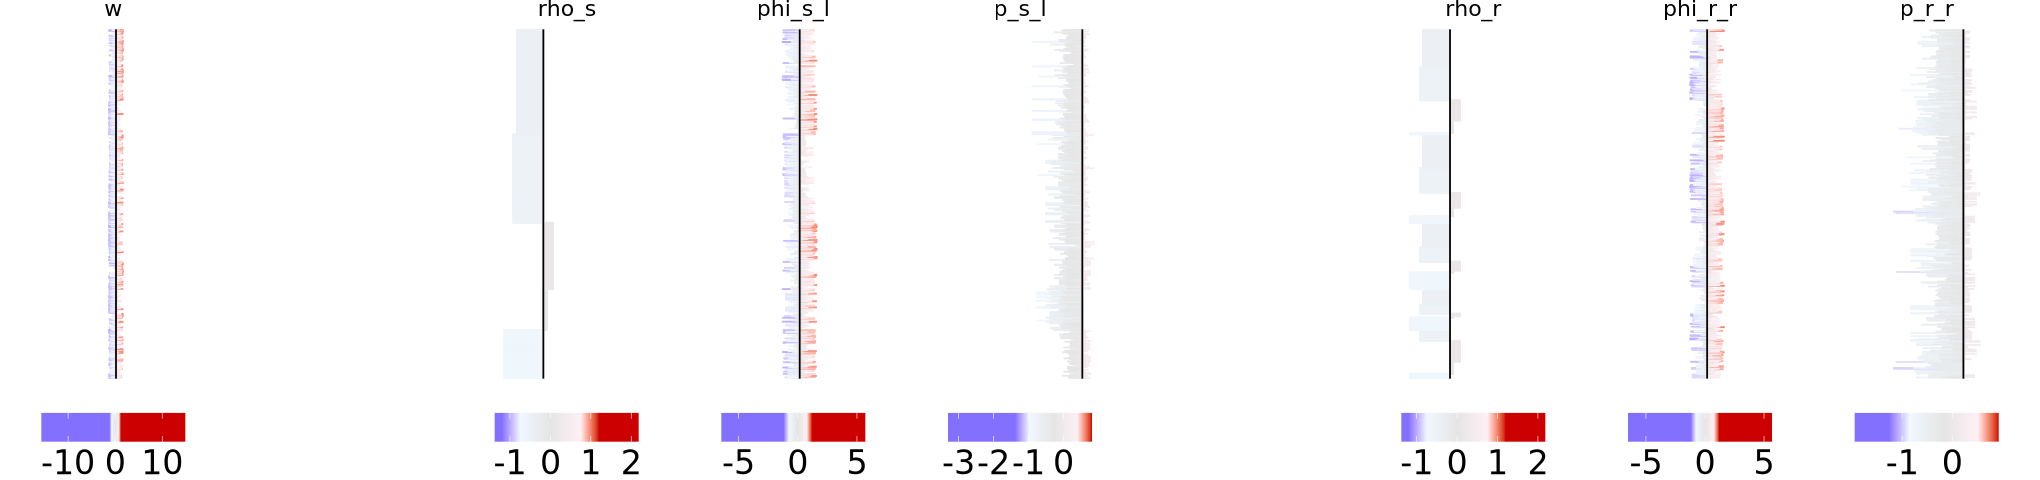

In [28]:
options(repr.plot.width = 17
       ,repr.plot.height = 4)

IDs <- as.character(c(ordered_IDs$ID_order_no_change))
forestplot_for_category(IDs)

[1] "531 interactions in this category"


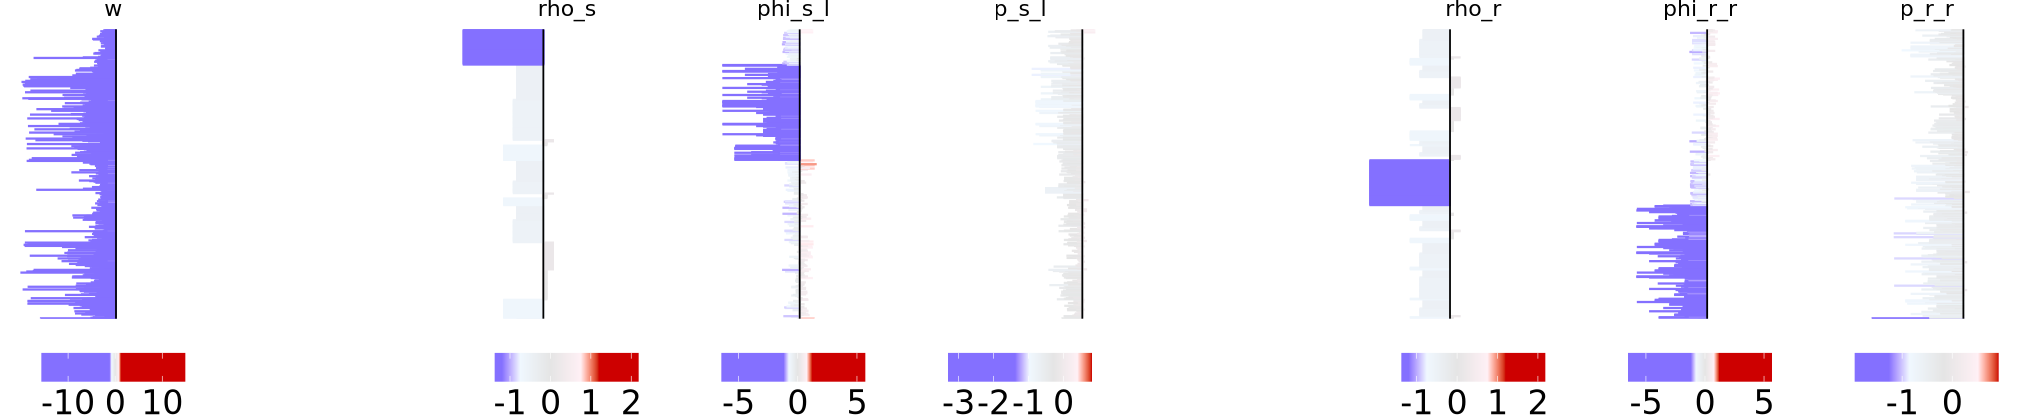

In [29]:
options(repr.plot.width = 17
       ,repr.plot.height = 3.5
       )

IDs <- as.character(c(ordered_IDs$ID_order_rho_s_only_down
                         ,ordered_IDs$ID_order_phi_s_only_down
                         ,ordered_IDs$ID_order_p_s_only_down
                         ,ordered_IDs$ID_order_rho_r_only_down
                         ,ordered_IDs$ID_order_phi_r_only_down
                         ,ordered_IDs$ID_order_p_r_only_down
                     ))

forestplot_for_category(IDs)

[1] "1 interactions in this category"


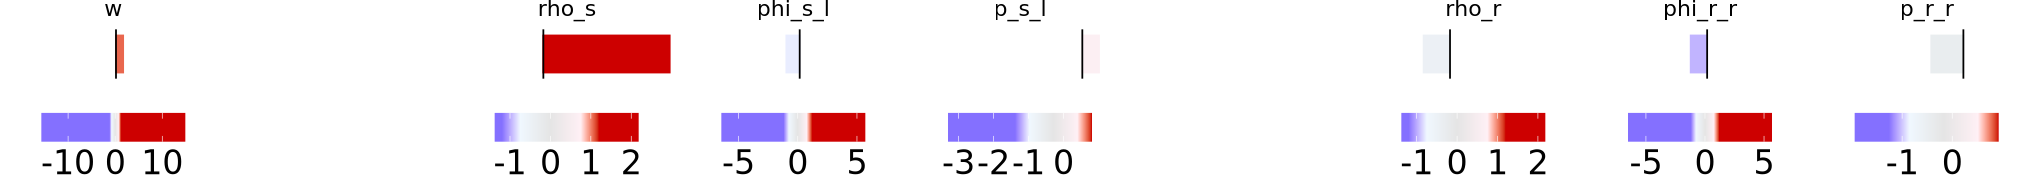

In [30]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_rho_s_only_up
                          ,ordered_IDs$ID_order_phi_s_only_up
                          ,ordered_IDs$ID_order_p_s_only_up
                          ,ordered_IDs$ID_order_rho_r_only_up
                          ,ordered_IDs$ID_order_phi_r_only_up
                          ,ordered_IDs$ID_order_p_r_only_up
                     ))

forestplot_for_category(IDs)

[1] "1039 interactions in this category"


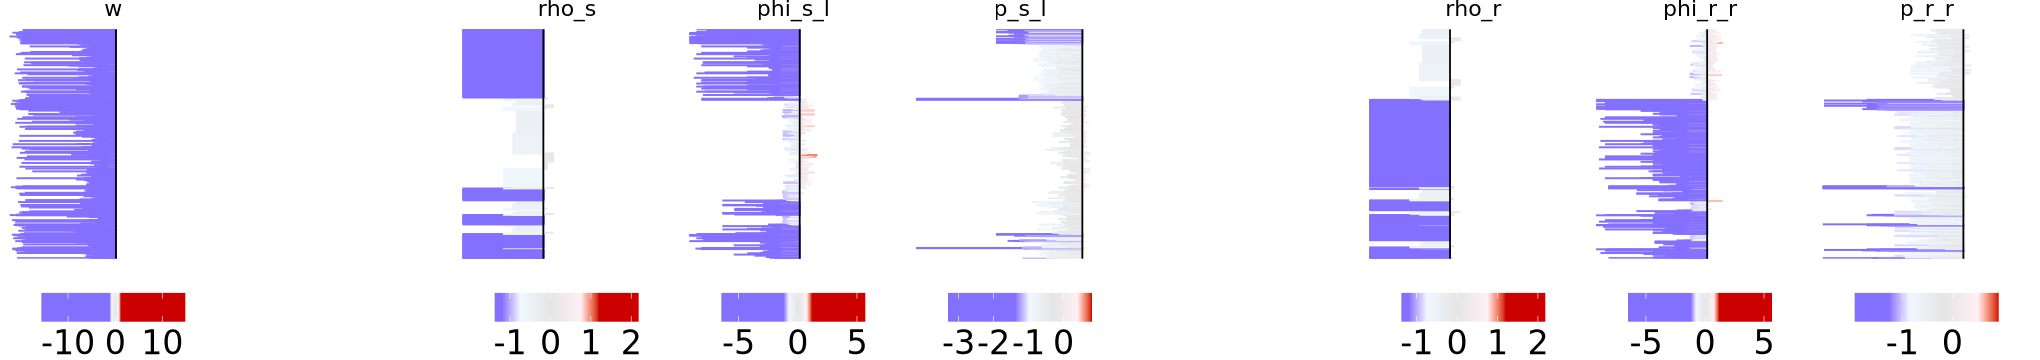

In [31]:
options(repr.plot.width = 17
       ,repr.plot.height = 3)

IDs <- as.character(c(ordered_IDs$ID_order_concordantDown_s
                          ,ordered_IDs$ID_order_concordantDown_r
                          ,ordered_IDs$ID_order_concordantDown_b_one_one
                          ,ordered_IDs$ID_order_concordantDown_b_one_several
                          ,ordered_IDs$ID_order_concordantDown_b_several_one
                          ,ordered_IDs$ID_order_concordantDown_b_several_several
                     ))

forestplot_for_category(IDs)

[1] "79 interactions in this category"


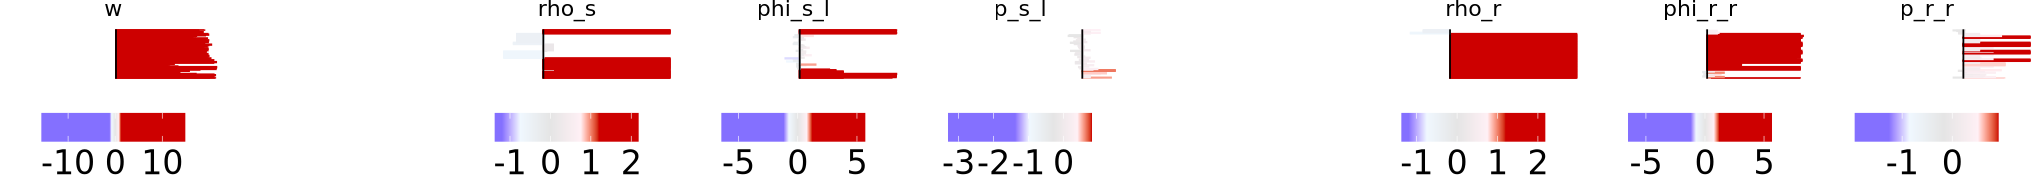

In [32]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_concordantUp_s
                          ,ordered_IDs$ID_order_concordantUp_r
                          ,ordered_IDs$ID_order_concordantUp_b_one_one
                          ,ordered_IDs$ID_order_concordantUp_b_one_several
                          ,ordered_IDs$ID_order_concordantUp_b_several_one
                          ,ordered_IDs$ID_order_concordantUp_b_several_several
                     ))

forestplot_for_category(IDs)

[1] "799 interactions in this category"


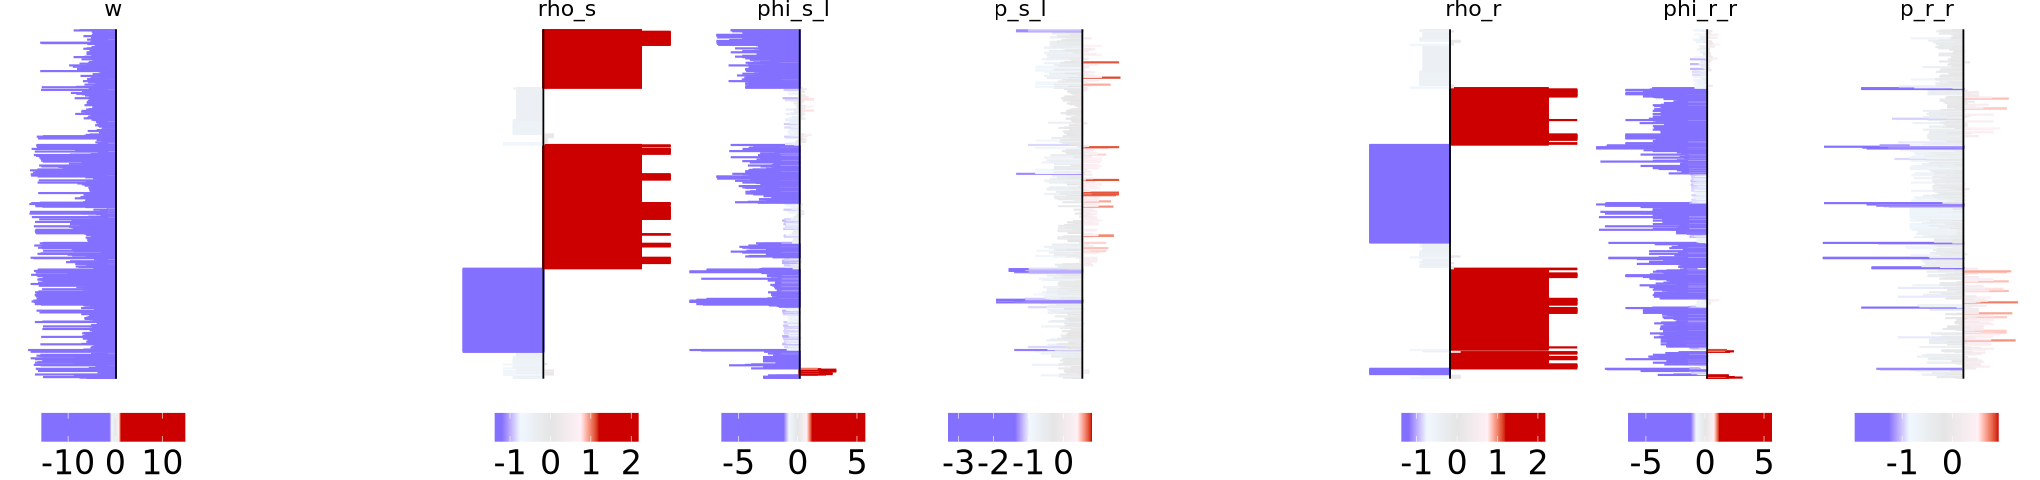

In [33]:
options(repr.plot.width = 17
       ,repr.plot.height = 4)

IDs <- as.character(c(ordered_IDs$ID_order_insuffDown_s
                          ,ordered_IDs$ID_order_insuffDown_r
                          ,ordered_IDs$ID_order_insuffDown_b
                     ))

forestplot_for_category(IDs)

[1] "17 interactions in this category"


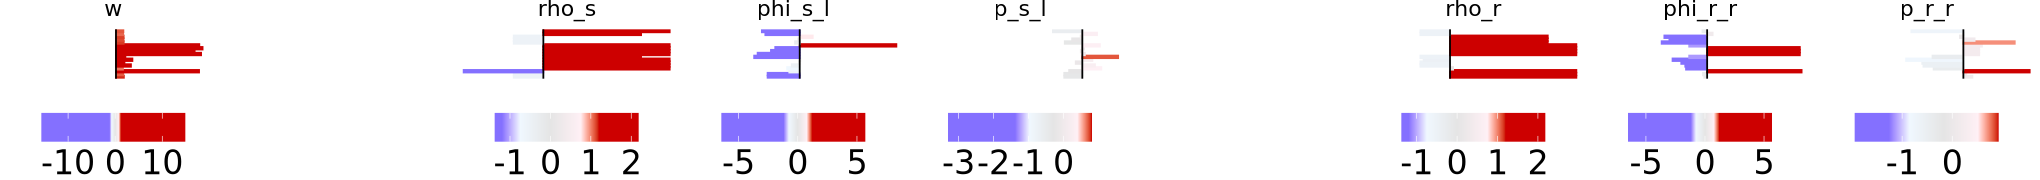

In [34]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_insuffUp_s
                          ,ordered_IDs$ID_order_insuffUp_r
                          ,ordered_IDs$ID_order_insuffUp_b
                     ))

forestplot_for_category(IDs)

[1] "1712 interactions in this category"


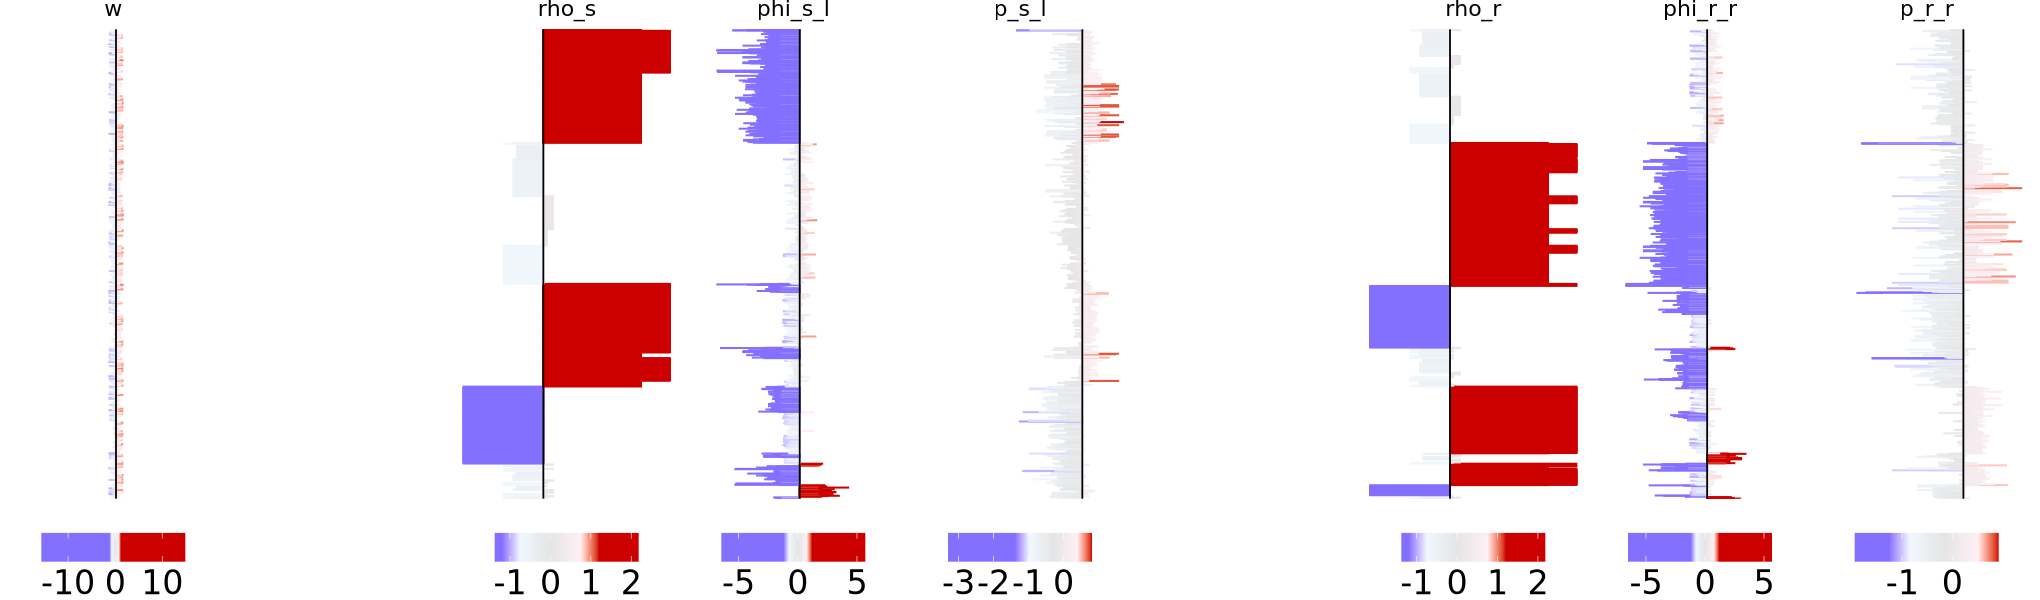

In [35]:
options(repr.plot.width = 17
       ,repr.plot.height = 5)

IDs <- as.character(c(ordered_IDs$ID_order_suffComp_s
                      ,ordered_IDs$ID_order_suffComp_r
                      ,ordered_IDs$ID_order_suffComp_b
                 ))

forestplot_for_category(IDs)

In [36]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/msolovey/miniconda3/envs/community_tutorial/lib/libopenblasp-r0.3.25.so

locale:
 [1] LC_CTYPE=de_DE.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridExtra_2.3         igraph_1.5.1          circlize_0.4.15      
[4] ComplexHeatmap_2.14.0 ggrepel_0.9.5         ggplot2_3.4.4        
[7] community_1.4.0      

loaded via a namespace (and not attached):
  [1] readxl_1.4.3                uuid_1.1-1                 
 